# Categorical Feature Encoding Challenge II V2

Ideas:
* Replace missing values with constant
* Add number of missing values in row as a feature
* Apply StandardScaler to created feature
* Apply Target to features that have many unique values
* Apply entity embedding layers for other features + Keras
* Apply OHE for other features + Logit
* Blend Logit and Keras

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

import os
for dirname, _, filenames in os.walk('./input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/submission.csv
./input/train.csv
./input/train_folds.csv
./input/test.csv
./input/sample_submission.csv


## Load data

In [2]:
train = pd.read_csv('./input/train.csv', index_col='id')
test = pd.read_csv('./input/test.csv', index_col='id')

In [3]:
train.head(3).T

id,0,1,2
bin_0,0,1,0
bin_1,0,1,1
bin_2,0,0,0
bin_3,F,F,F
bin_4,N,Y,N
nom_0,Red,Red,Red
nom_1,Trapezoid,Star,NaN
nom_2,Hamster,Axolotl,Hamster
nom_3,Russia,NaN,Canada
nom_4,Bassoon,Theremin,Bassoon


In [4]:
def summary(df):
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    return summary


summary(train)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,bin_0,float64,17894,2,0,1,0
1,bin_1,float64,18003,2,0,1,1
2,bin_2,float64,17930,2,0,0,0
3,bin_3,object,18014,2,F,F,F
4,bin_4,object,18047,2,N,Y,N
5,nom_0,object,18252,3,Red,Red,Red
6,nom_1,object,18156,6,Trapezoid,Star,NaN
7,nom_2,object,18035,6,Hamster,Axolotl,Hamster
8,nom_3,object,18121,6,Russia,NaN,Canada
9,nom_4,object,18035,4,Bassoon,Theremin,Bassoon


## Handle missing values

Add number of missing values in row as a feature

In [5]:
train['missing_count'] = train.isnull().sum(axis=1)
test['missing_count'] = test.isnull().sum(axis=1)

Replace missing values with constants

In [6]:
missing_number = -99999
missing_string = 'MISSING_STRING'

In [7]:
numerical_features = [
    'bin_0', 'bin_1', 'bin_2',
    'ord_0',
    'day', 'month'
]

string_features = [
    'bin_3', 'bin_4',
    'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5',
    'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9'
]

In [9]:
def impute(train, test, columns, value):
    for column in columns:
        train[column] = train[column].fillna(value)
        test[column] = test[column].fillna(value)

In [10]:
impute(train, test, numerical_features, missing_number)
impute(train, test, string_features, missing_string)

## Feature engineering

Split 'ord_5' preserving missing values

In [11]:
train['ord_5_1'] = train['ord_5'].str[0]
train['ord_5_2'] = train['ord_5'].str[1]

train.loc[train['ord_5'] == missing_string, 'ord_5_1'] = missing_string
train.loc[train['ord_5'] == missing_string, 'ord_5_2'] = missing_string

train = train.drop('ord_5', axis=1)


test['ord_5_1'] = test['ord_5'].str[0]
test['ord_5_2'] = test['ord_5'].str[1]

test.loc[test['ord_5'] == missing_string, 'ord_5_1'] = missing_string
test.loc[test['ord_5'] == missing_string, 'ord_5_2'] = missing_string

test = test.drop('ord_5', axis=1)

In [12]:
simple_features = [
    'missing_count'
]

oe_features = [
    'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
    'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
    'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5_1', 'ord_5_2',
    'day', 'month'
]

ohe_features = oe_features

target_features = [
    'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9'
]

## Extract target variable

In [13]:
y_train = train['target'].copy()
x_train = train.drop('target', axis=1)
del train

x_test = test.copy()
del test

## Standard scaler

In [14]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
simple_x_train = scaler.fit_transform(x_train[simple_features])
simple_x_test = scaler.transform(x_test[simple_features])

## OHE

In [15]:
from sklearn.preprocessing import OneHotEncoder


ohe = OneHotEncoder(dtype='uint16', handle_unknown="ignore")
ohe_x_train = ohe.fit_transform(x_train[ohe_features])
ohe_x_test = ohe.transform(x_test[ohe_features])

## Ordinal encoder

In [16]:
from sklearn.preprocessing import OrdinalEncoder


oe = OrdinalEncoder()
oe_x_train = oe.fit_transform(x_train[oe_features])
oe_x_test = oe.transform(x_test[oe_features])

## Target encoder

In [17]:
from category_encoders import TargetEncoder
from sklearn.model_selection import StratifiedKFold

In [18]:
def transform(transformer, x_train, y_train, cv):
    oof = pd.DataFrame(index=x_train.index, columns=x_train.columns)
    for train_idx, valid_idx in cv.split(x_train, y_train):
        x_train_train = x_train.loc[train_idx]
        y_train_train = y_train.loc[train_idx]
        x_train_valid = x_train.loc[valid_idx]
        transformer.fit(x_train_train, y_train_train)
        oof_part = transformer.transform(x_train_valid)
        oof.loc[valid_idx] = oof_part
    return oof

In [19]:
target = TargetEncoder(drop_invariant=True, smoothing=0.2)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
target_x_train = transform(target, x_train[target_features], y_train, cv).astype('float')

target.fit(x_train[target_features], y_train)
target_x_test = target.transform(x_test[target_features]).astype('float')

## Merge for Logit

In [20]:
import scipy


x_train = scipy.sparse.hstack([ohe_x_train, simple_x_train, target_x_train]).tocsr()
x_test = scipy.sparse.hstack([ohe_x_test, simple_x_test, target_x_test]).tocsr()

## Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

logit = LogisticRegression(C=0.54321, solver='lbfgs', max_iter=10000)
rdc=RandomForestClassifier(random_state=0,n_jobs=-1)
logit.fit(x_train, y_train)
rdc.fit(x_train, y_train)
y_pred_logit = logit.predict_proba(x_test)[:, 1]
y_pred_rdc = rdc.predict_proba(x_test)[:, 1]

## Merge for Keras

In [27]:
x_train = np.concatenate((oe_x_train, simple_x_train, target_x_train), axis=1)
x_test = np.concatenate((oe_x_test, simple_x_test, target_x_test), axis=1)

In [28]:
categorial_part = oe_x_train.shape[1]

## Keras

In [29]:
import tensorflow as tf

In [30]:
from sklearn.metrics import roc_auc_score


def auc(y_true, y_pred):
    def fallback_auc(y_true, y_pred):
        try:
            return roc_auc_score(y_true, y_pred)
        except:
            return 0.5
    return tf.py_function(fallback_auc, (y_true, y_pred), tf.double)

In [31]:
def make_model(data, categorial_part):
    
    inputs = []
    
    categorial_outputs = []
    for idx in range(categorial_part):
        n_unique = np.unique(data[:,idx]).shape[0]
        n_embeddings = int(min(np.ceil(n_unique / 2), 50))
        inp = tf.keras.layers.Input(shape=(1,))
        inputs.append(inp)
        x = tf.keras.layers.Embedding(n_unique + 1, n_embeddings)(inp)
        x = tf.keras.layers.SpatialDropout1D(0.3)(x)
        x = tf.keras.layers.Reshape((n_embeddings,))(x)
        categorial_outputs.append(x)
    
    x1 = tf.keras.layers.Concatenate()(categorial_outputs)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    
    inp = tf.keras.layers.Input(shape=(data.shape[1] - categorial_part,))
    inputs.append(inp)
    x2 = tf.keras.layers.BatchNormalization()(inp)
    
    x = tf.keras.layers.Concatenate()([x1, x2])
    x = tf.keras.layers.Dense(300, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    y = tf.keras.layers.Dense(1, activation='sigmoid', name='dense_output')(x)
    
    print('Expected number of inputs:', len(inputs))
    model = tf.keras.Model(inputs=inputs, outputs=y)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), metrics=['accuracy', auc])
    return model

In [32]:
def make_inputs(data, categorial_part):
    inputs = []
    for idx in range(categorial_part):
        inputs.append(data[:, idx])
    inputs.append(data[:, categorial_part:])
    return inputs

In [33]:
from sklearn.model_selection import KFold
import tensorflow.keras.backend as K


n_splits = 50

trained_estimators = []
histories = []
scores = []

cv = KFold(n_splits=n_splits, random_state=42)
for train_idx, valid_idx in cv.split(x_train, y_train):
    
    x_train_train = x_train[train_idx]
    y_train_train = y_train[train_idx]
    x_train_valid = x_train[valid_idx]
    y_train_valid = y_train[valid_idx]
    
    K.clear_session()
    
    estimator = make_model(x_train, categorial_part)
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=10,
                                          verbose=1, mode='max', restore_best_weights=True)
    
    rl = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, min_lr=1e-6, mode='max', verbose=1)
    
    history = estimator.fit(make_inputs(x_train_train, categorial_part), y_train_train, batch_size=1024, epochs=100, callbacks=[es, rl],
                            validation_data=(make_inputs(x_train_valid, categorial_part), y_train_valid))
    trained_estimators.append(estimator)
    histories.append(history)
    
    oof_part = estimator.predict(make_inputs(x_train_valid, categorial_part))
    score = roc_auc_score(y_train_valid, oof_part)
    print('Fold score:', score)
    scores.append(score)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Expected number of inputs: 20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 588000 samples, validate on 12000 samples
Epoch 1/100
588000/588000 [==============================] - 4s 6us/sample - loss: 0.5250 - acc: 0.7705 - auc: 0.5658 - val_loss: 0.4942 - val_acc: 0.8123 - val_auc: 0.6854
Epoch 2/100
588000/588000 [==============================] - 3s 5us/sample - loss: 0.4634 - acc: 0.8083 - auc: 0.6554 - val_loss: 0.4295 - val_acc: 0.8173 - val_auc: 0.7421
Epoch 3/100
588000/588000 [==============================] - 3s 5us/sample - loss: 0.4437 - acc: 0.8119 - auc: 0.7025 - val_loss: 0.4153 - val_acc: 0.8230 - val_auc: 0.7635
Epoch 4/100
588000/588000 [==============================] - 3s 5us/sa

In [34]:
print('Mean score:', np.mean(scores))

Mean score: 0.785694722039701


## Visualize

KeyError: 'accuracy'

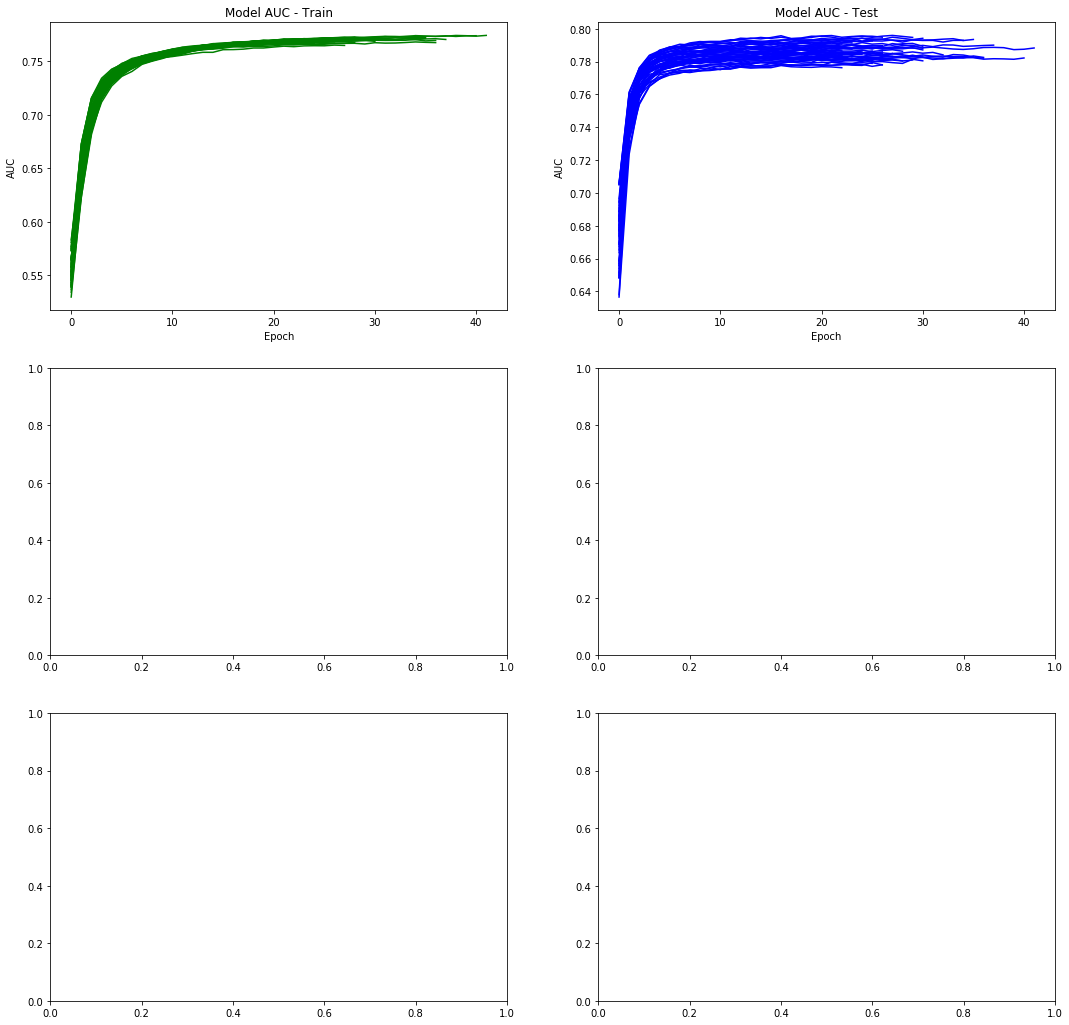

In [37]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(3, 2, figsize=(18,18))

# AUC
for h in histories:
    axs[0,0].plot(h.history['auc'], color='g')
axs[0,0].set_title('Model AUC - Train')
axs[0,0].set_ylabel('AUC')
axs[0,0].set_xlabel('Epoch')

for h in histories:
    axs[0,1].plot(h.history['val_auc'], color='b')
axs[0,1].set_title('Model AUC - Test')
axs[0,1].set_ylabel('AUC')
axs[0,1].set_xlabel('Epoch')

# accuracy
for h in histories:
    axs[1,0].plot(h.history['accuracy'], color='g')
axs[1,0].set_title('Model accuracy - Train')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].set_xlabel('Epoch')

for h in histories:
    axs[1,1].plot(h.history['val_accuracy'], color='b')
axs[1,1].set_title('Model accuracy - Test')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].set_xlabel('Epoch')

# loss
for h in histories:
    axs[2,0].plot(h.history['loss'], color='g')
axs[2,0].set_title('Model loss - Train')
axs[2,0].set_ylabel('Loss')
axs[2,0].set_xlabel('Epoch')

for h in histories:
    axs[2,1].plot(h.history['val_loss'], color='b')
axs[2,1].set_title('Model loss - Test')
axs[2,1].set_ylabel('Loss')
axs[2,1].set_xlabel('Epoch')

fig.show()

## Predict

In [38]:
len(trained_estimators)

50

In [46]:
trained_estimators[0]

In [44]:
y_pred = np.zeros(x_test.shape[0])
x_test_inputs = make_inputs(x_test, categorial_part)
for estimator in trained_estimators:
    y_pred += estimator.predict(x_test_inputs).reshape(-1) / len(trained_estimators)

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(), dtype=float32) is not an element of this graph.

In [32]:
y_pred_keras = y_pred

## Blend Logit and Keras

In [33]:
y_pred = np.add(y_pred_logit, y_pred_rdc,y_pred_keras) / 3

## Submit predictions

In [34]:
submission = pd.read_csv('../input/cat-in-the-dat-ii/sample_submission.csv', index_col='id')
submission['target'] = y_pred
submission.to_csv('logit_keras.csv')

In [35]:
submission.head()

,target
id,
600000,0.146665
600001,0.280411
600002,0.163589
600003,0.113939
600004,0.157558
